# Assignment 1
Author: Luis Eduardo "Luise" San Martin

In [14]:
import assignment1
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

## Problem 1: Data Acquisition and Analysis

1. Download reported crime data from Chicago open data portal for 2017 and 2018.

**Answer:**

We've set a function in the assignment1.py file to help with this:

In [2]:
crimes = assignment1.data_on_crimes()
crimes_df = pd.DataFrame.from_dict(crimes)
#crimes_df

Now `crimes_df` is the dataframe with the crimes data.

2. Generate summary statistics for the crime reports data including but not limited to number of crimes of each type, how they change over time, and how they are different by neighborhood. Please use a combination of tables and graphs to present these summary stats.

**Answer:**

Number of crimes by year:

In [3]:
crimes_df.groupby("year").size()

year
2017    268096
2018    266278
dtype: int64

We can see that the number of crimes reported in 2017 and 2018 was quite similar. The difference between 2018 and 2017 was:

In [4]:
crimes_df.groupby("year").size()[1] - crimes_df.groupby("year").size()[0]

-1818

The percentage change in the number of crimes between 2018 and 2017 was:

In [5]:
round((crimes_df.groupby("year").size()[1] - crimes_df.groupby("year").size()[0])/crimes_df.groupby("year").size()[0] * 100, 1)

-0.7

Number of crimes by type and year:

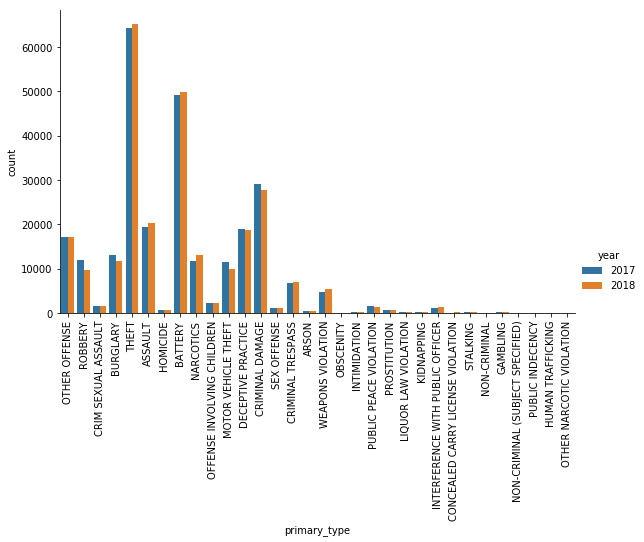

In [6]:
type_year = sns.catplot(x='primary_type', hue='year', kind='count', data=crimes_df, aspect=1.6)
type_year.set_xticklabels(rotation=90)

Both in 2017 and 2018, the most frequent types of crimes registered were theft, battery and criminal damage.

Checking the number of crimes by ward:

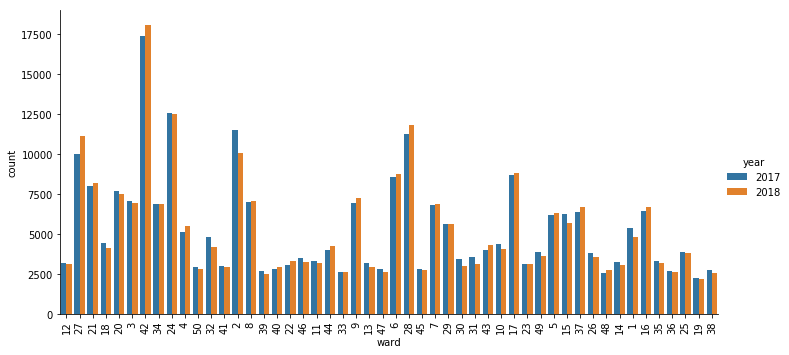

In [7]:
ward_year = sns.catplot(x='ward', hue='year', kind='count', data=crimes_df, aspect=2)
ward_year.set_xticklabels(rotation=90)

The wards with the most number of crimes recorded are wards 42, 24 and 28. Interestingly, some wards seem to present important variations in the number of crimes reported between 2018 and 2017.

Now we'll check which wards have the greatest increases and decreases in reported crimes between 2017 and 2018.

In [8]:
crimes_wards_df = crimes_df.groupby(['ward', 'year']).size().unstack()
crimes_wards_df['variation'] = crimes_wards_df['2018'] - crimes_wards_df['2017']
crimes_wards_df['perc_var'] = crimes_wards_df['variation'] / crimes_wards_df['2017']
crimes_wards_df['wards'] = pd.to_numeric(crimes_wards_df.index)
crimes_wards_df = crimes_wards_df.sort_values('perc_var')

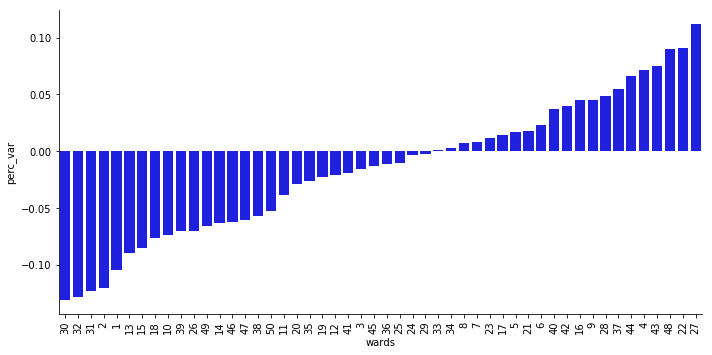

In [9]:
ward_variation_year = sns.catplot(x='wards', y='perc_var', order=crimes_wards_df['wards'], data=crimes_wards_df, aspect=2, kind='bar', color='B')
ward_variation_year.set_xticklabels(rotation=90)

## Problem 2: Data Augmentation and APIs

All of the crime data you just analyzed have a block address and lat/long fields. The task now is to augment that data with American Community Survey data. For each crime report, use one of the census APIs to get some additional data (at least 3-4 useful variables) about the block or zipcode where the crime report came from. This could include information about demographics of the block or zipcode (race, income, family size, etc.).

Based on this augmented data, provide some descriptive statistics to describe:

1. What types of blocks have reports of “Battery”?

**Answer:**

First, we're going to use the ACS API to download demographic data at the block-group level. We'll do this for all the block groups in the Cook county.

We'll include 4 variables: total population, Black or African-American population, median household income in the past 12 months in 2017 inflation-adjusted dollars and average household size of occupied units.

In [10]:
blocks_data = assignment1.data_on_blocks()
blocks_data_df = pd.DataFrame.from_records(blocks_data)
blocks_data_df.columns = blocks_data_df.iloc[0]
blocks_data_df = blocks_data_df.drop(0)

We've also downloaded shapefiles describing the block groups. We'll use them to conduct a spatial join between our initial crimes dataframe (recall that we have the latitude and longitude of the place where the crime was committed), get the block group ID, and use it to merge the crimes dataframe with the demographic variables obtained from the ACS.

In [11]:
blocks_map = gpd.read_file('data/tl_2018_17_bg.shp')

Now we'll transform the crimes_df dataframe into a geodataframe so we can conduct a spatial join.

In [22]:
points = list(Point(xy) for xy in zip(pd.to_numeric(crimes_df.longitude), pd.to_numeric(crimes_df.latitude)))
crimes_gdf = GeoDataFrame(crimes_df.drop(['longitude', 'latitude'], axis=1), geometry=points)

And then we'll set the same coordinate reference system in both geodataframes and conduct the spatial join: